# Интернет-магазин и его гипотезы
Цель - увеличить выручку магазина, протестировав наиболее приоритетные гипотезы и проведя А/В-тест.

### План исследования
1. Приоритизация гипотез:
    - [С помощью фреймворка ICE](#ICE) 
    - [С помощью фреймворка RICE](#RICE) 
    - [Выводы](#results) 
    
    
2. Анализ A/B-теста
    - [Кумулятивная выручка по группам](#cumulativeRevenue) 
    - [Кумулятивный средний чек по группам](#cumulativeAverageCheck) 
    - [Относительное изменение кумулятивного среднего чека группы B к группе A](#relationAverageCheck) 
    - [Кумулятивная конверсия по группам](#cumulativeConversion)
    - [Относительное изменение кумулятивной конверсии группы B к группе A](#relationCumulativeConversion)     
    - [Распределение стоимости заказов по пользователям](#revenueByVisitor)
    - [Расчет 95 и 99 перцентилей для стоимости заказов по пользователям](#revenueByVisitorPercentile)
    - [Распределение количества заказов по пользователям](#ordersByVisitor)
    - [Расчет 95 и 99 перцентилей количества заказов на пользователя](#ordersByVisitorPercentile)
    - [Расчет статистической значимости различий в конверсии между группами по *«сырым»* данным](#conversionPvalue)
    - [Расчет статистической значимости различий в среднем чеке заказа между группами по *«сырым»* данным](#AverageCheckPvalue)
    - [Расчет статистической значимости различий в конверсии между группами по *«очищенным»* данным](#conversionPvalueFiltered)
    - [Расчет статистической значимости различий в среднем чеке заказа между группами по *«очищенным»* данным](#AverageCheckPvalueFiltered)
    - [Выводы по результатам анализа А/В теста](#conclusions) 

### Входные данные:
Файл /datasets/hypothesis.csv:
- _Hypothesis_ - краткое описание гипотезы;
- _Reach_ - охват пользователей по 10-балльной шкале;
- _Impact_ - влияние на пользователей по 10-балльной шкале;
- _Confidence_ - уверенность в гипотезе по 10-балльной шкале;
- _Efforts_ - затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv:
- _transactionId_ - идентификатор заказа;
- _visitorId_ - идентификатор пользователя, совершившего заказ;
- _date_ - дата, когда был совершён заказ;
- _revenue_ - выручка заказа;
- _group_ - группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:
- _date_ - дата;
- _group_ - группа A/B-теста;
- _visitors_ - количество пользователей в указанную дату в указанной группе A/B-теста

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [67]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

### 1. Приоритизация гипотез

#### 1.1 Фреймворк ICE  <a id="ICE">

In [68]:
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round(1)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0


по ICE наиболее приоритетные гипотезы:
- №8 "Запустить акцию, дающую скидку на товар в день рождения";
- №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей";
- №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

#### 1.2 Фреймворк RICE  <a id="RICE">

In [69]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,3.0


по RICE наиболее приоритетные гипотезы:
- №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";
- №2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа";
- №0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей";
- №6 "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"

### Выводы:  <a id="results">
При применении фреймвормка RICE наиболее приоритетными стали гипотезы №7 И №2 вследствие того, что именно эти изменения охватят бОльшее количество пользователей. Лучше всего начать с гипотезы №7. 
    
Также целесообразно провести еще одно обсуждение параметра охвата Reach для гипотез №0 и №8, пересмотр значения данного параметра может сильно изменить приоритеты.

### 2. Анализ A/B-теста

In [70]:
# приведем к формату datetime
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [71]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [72]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [73]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [74]:
# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = (datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 
          'group':'max', 
          'transactionId':pd.Series.nunique, 
          'visitorId':pd.Series.nunique, 
          'revenue':'sum'}), axis=1)
    .sort_values(by=['date','group'])
                   )

In [75]:
# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = (datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)
    .sort_values(by=['date','group'])
                     )

In [76]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Кумулятивная выручка по группам <a id="cumulativeRevenue">

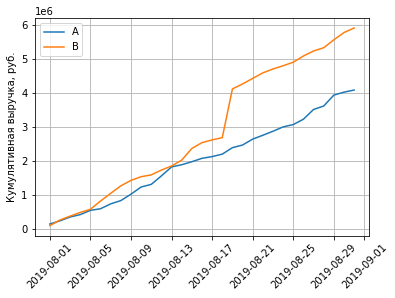

In [77]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# cтроим график выручки групп А и B
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.grid(True)
plt.ylabel('Кумулятивная выручка, руб.')
plt.xticks(rotation=45)
plt.legend()
plt.show()

По графику видно, что выручка группы В увеличивается не равномерно, а имеет резкий рост в периоде между 17 и 21 августа, скорее всего в эту группу попали выбросы (например, очень большой заказ или очень много обычных заказов).

### Кумулятивный средний чек по группам <a id="cumulativeAverageCheck">

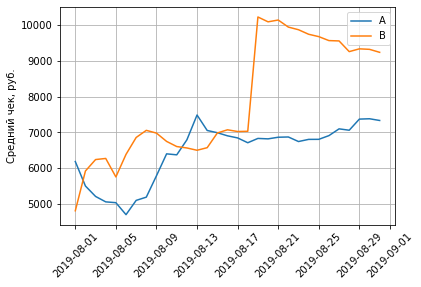

In [78]:
# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.grid(True)
plt.ylabel('Средний чек, руб.')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Можно сказать, что средний чек группы А установился (на уровне ~7000 руб), при этом средний чек группы B продолжает снижаться.  Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### Относительное изменение кумулятивного среднего чека группы B к A  <a id="relationAverageCheck">

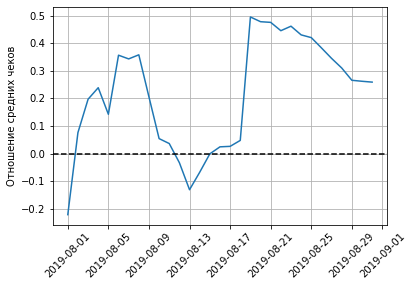

In [79]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Отношение средних чеков')
plt.grid(True)

Почти на протяжении всего периода средний чек В-группы превышает А-группу. 
~Я календарь переверну~ и на начало сенября, это превышение достигает 25%. Однако это связано, скорее всего,  с крупными заказами и выбросами попавшими в группу В, т.к. в нескольких точках график различия между группами резко «скачет».

Относительное изменение среднего чека в группе В по отношению к А продолжает снижаться, также требуется больше данных, чтобы прийти к реальному значению.

### Кумулятивная конверсия по группам <a id="cumulativeConversion">

(0.025, 0.04)

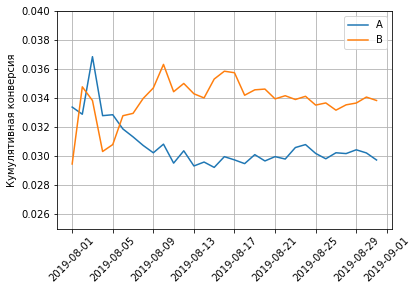

In [80]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)
plt.grid(True)


# задаем масштаб оси Y, чтобы видеть устаканилось значение или нет
plt.ylim((0.025, 0.04))

Конверсия группы А зафиксировалась на уровне 0.030, для группы В график почти установился, но пока неоднозначен, как будто конверсия плавно снижается. Здесь есть смысл продолжить тест на одну-две недели для получения более однозначных результатов. На текущий момент конверсия в группе В (0.034) превышает группу А примерно на 14%.

###  Относительное изменение кумулятивной конверсии группы B к  A  <a id="relationCumulativeConversion">

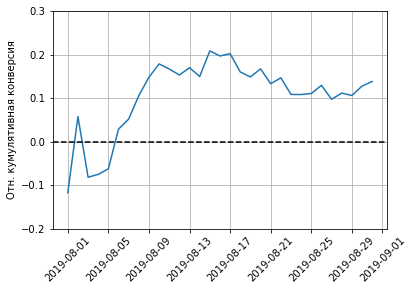

In [81]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xticks(rotation=45)
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.2, 0.3)
plt.ylabel('Отн. кумулятивная конверсия')
plt.show()

Отношение конверсии группы В к А ещё не установилось и плавно снижается. Исходя из данного графика также есть смысл продолжить тест для достижения стабильного значения, ещё примерно 1-2 недели.

### Распределение стоимости заказов по пользователям <a id="revenueByVisitor">

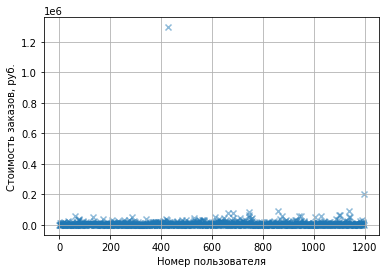

In [82]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], marker='x', alpha=0.5)
plt.xlabel('Номер пользователя')
plt.ylabel('Стоимость заказов, руб.')
plt.grid(True)

Есть посетители магазина с явно выбивающимися значениями стоимости заказа в ~200000 и ~1300000 руб, а также неявные выбросы, которые сейчас сливаются в общем массеве точек. Найдем их далее с помощью перцентилей.

### Расчет 95 и 99 перцентилей для стоимости заказов по пользователям <a id="revenueByVisitorPercentile">

In [83]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Примем в качестве границы для пользователей с аномально большой стоимостью заказа величину 28000 руб.

### Распределение количества заказов по пользователям<a id="ordersByVisitor">

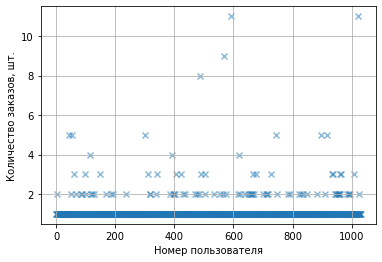

In [84]:
OrdersByVisitor = orders.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
OrdersByVisitor.columns = ['visitorId', 'orders_cnt']
x_values = pd.Series(range(0,len(OrdersByVisitor['orders_cnt'])))
plt.scatter(x_values, OrdersByVisitor['orders_cnt'], marker='x', alpha=0.5)
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов, шт.')
plt.grid(True)

Среди покупателей интернет-магазина преобладают покупатели с одним и двумя заказами. Есть также пкупатели с количеством заказов от 3 до 11. Опредилим границу какое количество заказов считать аномальным ниже с помощью перцентилей.

### Расчет 95 и 99 перцентилей количества заказов на пользователя<a id="ordersByVisitorPercentile">

In [85]:
print(np.percentile(OrdersByVisitor['orders_cnt'], [95, 99]))

[2. 4.]


Не более 5% процентов покупателей совершают более двух заказов (т.е. три и больше) и не более 1% процентов покупателей совершают более четырех заказов (т.е. пять и больше). 

Т.к. два заказа с точки зрения здравого смысла не является чем-то необычным (тут, конечно, надо учитывать специфику товаров магазина, вдруг это магазин квартир =), то примем в качестве границы для пользователей с аномально большим количеством заказов величину в четыре заказа.

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным <a id="conversionPvalue">

In [86]:
# количество посетителей интернет-магазина в день группы А нарастающим итогом
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = (visitorsADaily
                    .apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                    .agg({'date':'max', 'visitorsPerDateA':'sum'}), axis=1))         
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# количество посетителей интернет-магазина в день группы B нарастающим итогом
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = (visitorsBDaily
                    .apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                    .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1))
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [87]:
# количество покупателей интернет-магазина в день группы А нарастающим итогом
ordersADaily = (orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]
                .groupby('date', as_index=False)\
                .agg({'transactionId':'nunique', 'revenue':'sum'})
               )
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = (ordersADaily
                    .apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                    .agg({'date':'max',
                          'ordersPerDateA':'sum',
                          'revenuePerDateA':'sum'}), axis=1)
                    .sort_values(by=['date'])
                      )
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# количество покупателей интернет-магазина в день группы В нарастающим итогом
ordersBDaily = (orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]
                .groupby('date', as_index=False)
                .agg({'transactionId' : pd.Series.nunique, 'revenue':'sum'})
               )
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = (ordersBDaily
                      .apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                      .agg({'date' : 'max',
                            'ordersPerDateB':'sum',
                            'revenuePerDateB':'sum'}), axis=1)
                      .sort_values(by=['date'])
                     )
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [88]:
# сведем в большую таблицу
data = (ordersADaily
        .merge(ordersBDaily, left_on='date', right_on='date', how='left')
        .merge(ordersACummulative, left_on='date', right_on='date', how='left')
        .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
        .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
       )

In [89]:
# для каждого пользователя групп А и В (которые заказывали хотя бы 1 раз) запишем число совершённых заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

In [90]:
# добавим тех пользовалетей, которые ничего не заказывали (как объект Series c нулями). Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [91]:
# проведем тест Манна-Уитни по данным количества заказов
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

# посчитаем конверсию в группах А и В как сумму заказов деленную на количество посетителей
conversionA, conversionB = sampleA.mean(), sampleB.mean()
print('Конверсия группы А - {:.2%}, группы B - {:.2%}'.format(conversionA, conversionB))
print('Относительный прирост конверсии группы В составляет {0:.2%}'.format(conversionB/conversionA - 1))

Значение p-value: 0.008
Конверсия группы А - 2.97%, группы B - 3.38%
Относительный прирост конверсии группы В составляет 13.81%


Т.к. p-value 0.008 меньше 0.05, значит отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет. Соответственно, принимаем альтернативную, что есть статистически значимое различие между значениями конверсии, а именно +13.81% в пользу группы В.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным <a id="AverageCheckPvalue">

In [92]:
# проведем тест Манна-Уитни по данным выручки
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

# посчитаем средний чек в группах А и В как суммарную выручку в данной группе деленную на количество покупателей
AverageCheckA = orders[orders['group']=='A']['revenue'].mean()
AverageCheckB = orders[orders['group']=='B']['revenue'].mean()
print('Средний чек группы А - {:.2f} руб, группы B - {:.2f} руб'.format(AverageCheckA, AverageCheckB))
print('Относительный прирост среднего чек группы В составляет {0:.2%}'.format(AverageCheckB/AverageCheckA - 1))

Значение p-value: 0.365
Средний чек группы А - 7333.58 руб, группы B - 9230.88 руб
Относительный прирост среднего чек группы В составляет 25.87%


Т.к. p-value 0.365 больше 0.05, значит  нет оснований отвергать нулевую гипотезу о том, что статистически значимых различий в величине среднего чека между группами нет. Следовательно, превышение среднего чека в группе В на +25.87% не является статистически значимым.

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным  <a id="conversionPvalueFiltered">
_Итак, принимаем за аномальных покупателей тех, кто совершил заказ дороже 28 000 рублей или совершил более 4 заказов. Так мы уберём не более 5% покупателей с дорогими заказами и не более 1% с аномально большим числом заказов._

In [93]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Всего аномальных пользователей {} человек'.format(abnormalUsers.shape[0]))

Всего аномальных пользователей 59 человек


In [94]:
# отфильтруем выборки пользователей обеих групп. Также добавим тех пользовалетей, которые ничего не заказывали (как объект Series c нулями).
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [95]:
# проведем тест Манна-Уитни по данным количества заказов
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

# посчитаем конверсию в группах А и В как сумму заказов деленную на количество посетителей
conversionAFiltered, conversionBFiltered = sampleAFiltered.mean(), sampleBFiltered.mean()
print('Конверсия группы А - {:.2%}, группы B - {:.2%}'.format(conversionAFiltered, conversionBFiltered))
print('Относительный прирост конверсии группы В составляет {0:.2%}'.format(conversionBFiltered/conversionAFiltered - 1))

Значение p-value: 0.009
Конверсия группы А - 2.71%, группы B - 3.10%
Относительный прирост конверсии группы В составляет 14.53%


Результаты теста по "очищенным" данным существенно не изменились: p-value 0.009 меньше 0.05, значит по-прежнему есть статистически значимое различие между значениями конверсии. Преимущество конверсии в группе В по "очищенным" данным по сравнению с "сырыми" чуть выросло, с +13.81% до +14.53%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным  <a id="AverageCheckPvalueFiltered">

In [96]:
# проведем тест Манна-Уитни по "очищенным" от аномалий данным
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

# посчитаем средний чек в группах А и В как суммарную выручку в данной группе деленную на количество покупателей
AverageCheckAFiltered = orders[np.logical_and(orders['group']=='A', \
                        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()

AverageCheckBFiltered = orders[np.logical_and(orders['group']=='B', \
                        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()

print('Средний чек группы А - {:.2f} руб, группы B - {:.2f} руб'.format(AverageCheckAFiltered, AverageCheckBFiltered))
print('Относительный прирост среднего чек группы В составляет {0:.2%}'.format(AverageCheckBFiltered/AverageCheckAFiltered - 1))

Значение p-value: 0.481
Средний чек группы А - 5140.80 руб, группы B - 5069.73 руб
Относительный прирост среднего чек группы В составляет -1.38%


По "очищенным" данным результаты теста для среднего чека аналогичны результатам по "сырым" данным - 
нет оснований отвергать нулевую гипотезу о том, что статистически значимых различий в величине среднего чека между группами нет. 

Здесь следует отметить, что после очистки данных от аномально крупных заказов средний чек в группе В стал **меньше**, чем в группе А на 1.38% (по "сырым" данным он был **больше** на 25.87%). Опять же это преимущество среднего чека группы А не является статистически значимым.

### Выводы по результатам анализа А/В теста <a id="conclusions">

1. Если для бизнеса необходимы точные результаты теста и расходы на дополнительное время теста целесообразны, то необходимо продолжить тест, т.к.:
    - в выборку в начале и середине теста попали значительные аномальные значения выручки, которые хорошо видны по графику относительного изменения кумулятивного среднего чека группы В к группе А. Данное отношение продолжает снижаться, следовательно требуется больше данных, чтобы величина пришла к своему реальному значению. Дополнительно необходимо примерно две недели теста.
    - с учетом очистки имеющихся данных от указанных аномально крупных заказов, средний чек в группе В уже меньше, чем в группе А на 1.38% (по "сырым" данным он был больше на 25.87%). Это преимущество среднего чека группы А на текущий момент не является статистически значимым. Дополнительные данные, наиболее вероятно, приведут подтверждению отсутствия статистической значимости между средним чеками или наличием статистически значимого различия в пользу базовой группы А.
    - для конверсии достигнуто статистически значимое различие, относительное преимущество группы В +14.53% (конверсия группы А - 2.71%, группы B - 3.10%). Однако кумулятивный дневной график конверсии группы В пока неоднозначен, как будто конверсия плавно снижается. Для уверенных результатов по этому пункту необходимы дополнительные одна-две недели теста.
    
    
2. Если для бизнеса достаточны предварительные выводы по очищенным от выбросов данным и дополнительные расходы нецелесообразны, то следует остановить тест и:
    - следует зафиксировать наличие статистически значимого различия в конверсиях групп, относительное преимущество конверсии в группе В +14.53%;
    - следует зафиксировать, что статистически значимого различия между средними чеками в группах нет.